In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

data_file = "/home/awias/data/Summerschool_2025/metadata_fused.csv"

# Load your CSV file
df = pd.read_csv(data_file)

# Only keep the records where the substring 'train' is in filename_index
df = df[df['filename_index'].str.contains('train', na=False)].copy()

# Remove rows where taxonID_index is missing (since it's our target)
df = df.dropna(subset=['taxonID_index']).copy()

# Remove rows where at least two of the specified columns are NaN
cols_to_check = ['Habitat', 'Latitude', 'Longitude', 'Substrate', 'DateTimeOriginal']
df = df[df[cols_to_check].isnull().sum(axis=1) < 3].copy()

# Keep only specific columns from the dataframe
columns_to_keep = ['filename_index', 'Habitat', 'Latitude', 'Longitude', 'Substrate', 'DateTimeOriginal', 'taxonID_index']
df = df[columns_to_keep].copy()

In [12]:
def encode_datetime_features(df, datetime_col='DateTimeOriginal'):
    """
    Extract useful features from datetime column for XGBoost
    """
    df = df.copy()
    
    # Convert to datetime (handle the format YYYY:MM:DD HH:MM:SS)
    df[datetime_col] = pd.to_datetime(df[datetime_col], format='%Y:%m:%d %H:%M:%S', errors='coerce')
    
    # Option 1: Basic temporal features
    df['year'] = df[datetime_col].dt.year
    df['month'] = df[datetime_col].dt.month
    df['day'] = df[datetime_col].dt.day
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_year'] = df[datetime_col].dt.dayofyear
    df['week_of_year'] = df[datetime_col].dt.isocalendar().week
    
    # Option 2: Cyclical encoding (better for ML models)
    # Month as sine/cosine (captures seasonality)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Day of year as sine/cosine
    df['day_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Hour as sine/cosine
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Option 3: Seasonal categories
    df['season'] = df['month'].map({
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'autumn', 10: 'autumn', 11: 'autumn'
    })
    
    # Option 4: Time periods (for fungi, this might be important)
    df['is_growing_season'] = df['month'].isin([4, 5, 6, 7, 8, 9, 10]).astype(int)
    df['is_peak_season'] = df['month'].isin([8, 9, 10]).astype(int)  # Peak fungi season
    
    return df

In [13]:
df = encode_datetime_features(df, 'DateTimeOriginal')

df


,filename_index,Habitat,Latitude,Longitude,Substrate,DateTimeOriginal,taxonID_index,year,month,day,...,week_of_year,month_sin,month_cos,day_year_sin,day_year_cos,hour_sin,hour_cos,season,is_growing_season,is_peak_season
10161,fungi_train000009.jpg,coniferous woodland/plantation,56.016904,12.003886,soil,2020-07-09 15:49:12,180.0,2020.0,7.0,9.0,...,28,-0.500000,-8.660254e-01,-0.145799,-0.989314,-0.707107,-0.707107,summer,1,0
10164,fungi_train000012.jpg,natural grassland,54.981200,9.759120,soil,2017-09-27 22:27:36,37.0,2017.0,9.0,27.0,...,39,-1.000000,-1.836970e-16,-0.997917,-0.064508,-0.500000,0.866025,autumn,1,1
10172,fungi_train000020.jpg,Unmanaged coniferous woodland,54.991672,15.075319,soil,2020-09-30 13:59:06,54.0,2020.0,9.0,30.0,...,40,-1.000000,-1.836970e-16,-0.999991,0.004304,-0.258819,-0.965926,autumn,1,1
10188,fungi_train000036.jpg,Mixed woodland (with coniferous and deciduous ...,55.605675,8.337206,soil,2018-10-10 16:01:21,15.0,2018.0,10.0,10.0,...,41,-0.866025,5.000000e-01,-0.987349,0.158559,-0.866025,-0.500000,autumn,1,1
10202,fungi_train000050.jpg,Unmanaged coniferous woodland,55.254991,12.156747,leaf or needle litter,2018-09-27 17:04:11,72.0,2018.0,9.0,27.0,...,39,-1.000000,-1.836970e-16,-0.997917,-0.064508,-0.965926,-0.258819,autumn,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35980,fungi_train025828.jpg,natural grassland,56.645327,9.817572,soil,2018-10-16 10:30:31,18.0,2018.0,10.0,16.0,...,42,-0.866025,5.000000e-01,-0.965740,0.259512,0.500000,-0.866025,autumn,1,1
35982,fungi_train025830.jpg,coniferous woodland/plantation,56.627560,10.026530,leaf or needle litter,2011-09-01 14:14:16,75.0,2011.0,9.0,1.0,...,35,-1.000000,-1.836970e-16,-0.871706,-0.490029,-0.500000,-0.866025,autumn,1,1
36006,fungi_train025854.jpg,garden,55.891100,10.183600,soil,2008-10-29 00:44:39,126.0,2008.0,10.0,29.0,...,44,-0.866025,5.000000e-01,-0.875892,0.482508,0.000000,1.000000,autumn,1,1
36009,fungi_train025857.jpg,park/churchyard,55.783276,12.591566,soil,2019-08-21 10:23:42,142.0,2019.0,8.0,21.0,...,34,-0.866025,-5.000000e-01,-0.763889,-0.645348,0.500000,-0.866025,summer,1,1


In [14]:
# Encode categorical variables
label_encoders = {}
categorical_features = ['Habitat', 'Substrate']

for col in categorical_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
# Prepare final feature matrix (without date features)
feature_cols_final = ['Habitat_encoded', 'Latitude', 'Longitude', 'Substrate_encoded', 'year', 'month', 'day_of_year']

X = df[feature_cols_final]
y = df['taxonID_index']


In [15]:
# Encode target variable if it's categorical
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y.astype(str))

print(f"\nNumber of unique target classes: {len(target_encoder.classes_)}")
print(f"Target classes: {target_encoder.classes_[:10]}...")  # Show first 10

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train XGBoost model with GPU support
print("\nTraining XGBoost model on GPU...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss' if len(np.unique(y_encoded)) > 2 else 'logloss',
    tree_method='gpu_hist',  # Use GPU for training
    gpu_id=0,  # Use first GPU
    early_stopping_rounds=10
)


Number of unique target classes: 183
Target classes: ['0.0' '1.0' '10.0' '100.0' '101.0' '102.0' '103.0' '104.0' '105.0'
 '106.0']...

Training set size: (2631, 7)
Test set size: (658, 7)

Training XGBoost model on GPU...


In [16]:
# Add validation set for early stopping
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=True
)

/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:35:22] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  self.starting_round = model.num_boosted_rounds()
/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:5.12564
[1]	validation_0-mlogloss:5.05432
[2]	validation_0-mlogloss:4.99887
[3]	validation_0-mlogloss:4.94361
[4]	validation_0-mlogloss:4.89725
[5]	validation_0-mlogloss:4.85610
[6]	validation_0-mlogloss:4.81697
[7]	validation_0-mlogloss:4.78170
[8]	validation_0-mlogloss:4.74966
[9]	validation_0-mlogloss:4.71910
[10]	validation_0-mlogloss:4.68748
[11]	validation_0-mlogloss:4.66418
[12]	validation_0-mlogloss:4.64037
[13]	validation_0-mlogloss:4.61987
[14]	validation_0-mlogloss:4.60062
[15]	validation_0-mlogloss:4.58323
[16]	validation_0-mlogloss:4.56923
[17]	validation_0-mlogloss:4.55663
[18]	validation_0-mlogloss:4.54578
[19]	validation_0-mlogloss:4.53733
[20]	validation_0-mlogloss:4.52498
[21]	validation_0-mlogloss:4.51509
[22]	validation_0-mlogloss:4.50685
[23]	validation_0-mlogloss:4.49902
[24]	validation_0-mlogloss:4.49125
[25]	validation_0-mlogloss:4.48443
[26]	validation_0-mlogloss:4.47690
[27]	validation_0-mlogloss:4.46963
[28]	validation_0-mlogloss:4.4

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'mlogloss'


In [17]:
# Make predictions
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.3f}")

/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:43:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:43:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



Model Accuracy: 0.166



Feature Importance Ranking:
             feature  importance
3  Substrate_encoded    0.280439
0    Habitat_encoded    0.158568
6        day_of_year    0.120929
1           Latitude    0.117210
4               year    0.114036
2          Longitude    0.112412
5              month    0.096406


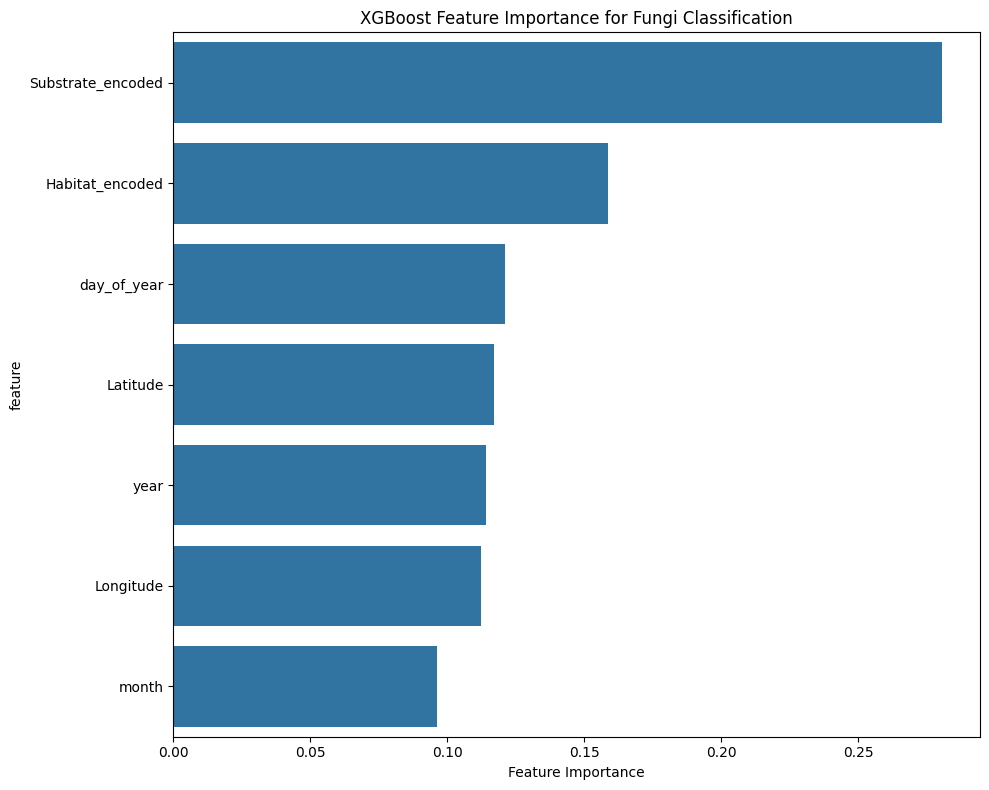


Detailed Feature Analysis:
Substrate_encoded: 0.2804
  Min: 0.00, Max: 17.00, Mean: 11.63

Habitat_encoded: 0.1586
  Min: 0.00, Max: 28.00, Mean: 9.68

day_of_year: 0.1209
  Min: 1.00, Max: 365.00, Mean: 252.27

Latitude: 0.1172
  Min: 54.56, Max: 57.71, Mean: 55.83

year: 0.1140
  Min: 1980.00, Max: 2031.00, Mean: 2016.23

Longitude: 0.1124
  Min: 8.10, Max: 15.13, Mean: 11.10

month: 0.0964
  Min: 1.00, Max: 12.00, Mean: 8.78



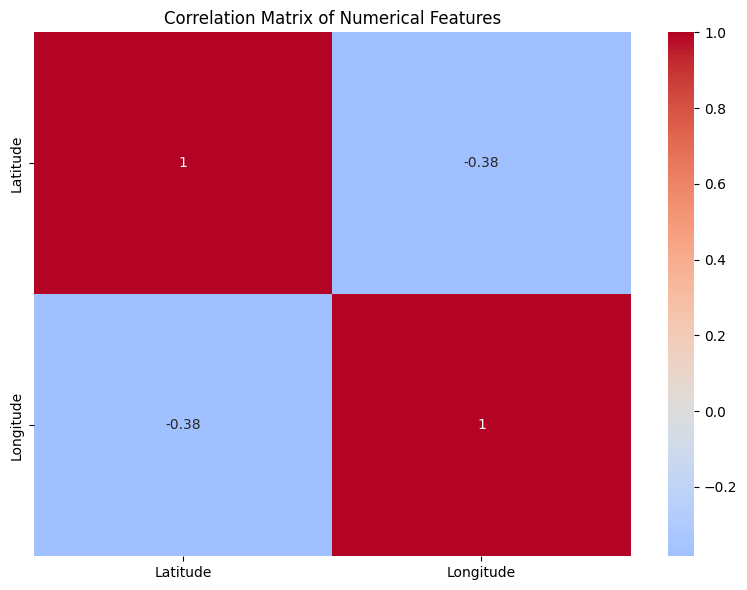


Categorical Feature Mappings:

Habitat:
  0: Acidic oak woodland
  1: Bog woodland
  2: Deciduous woodland
  3: Forest bog
  4: Mixed woodland (with coniferous and deciduous trees)
  5: Thorny scrubland
  6: Unmanaged coniferous woodland
  7: Unmanaged deciduous woodland
  8: Willow scrubland
  9: bog
  10: coniferous woodland/plantation
  11: ditch
  12: dune
  13: fallow field
  14: garden
  15: gravel or clay pit
  16: heath
  17: hedgerow
  18: improved grassland
  19: lawn
  20: meadow
  21: nan
  22: natural grassland
  23: other habitat
  24: park/churchyard
  25: roadside
  26: roof
  27: salt meadow
  28: wooded meadow, grazing forest

Substrate:
  0: bark
  1: bark of living trees
  2: catkins
  3: cones
  4: dead stems of herbs, grass etc
  5: dead wood (including bark)
  6: faeces
  7: leaf or needle litter
  8: living stems of herbs, grass etc
  9: mosses
  10: nan
  11: other substrate
  12: peat mosses
  13: soil
  14: stems of herbs, grass etc
  15: wood
  16: wood and

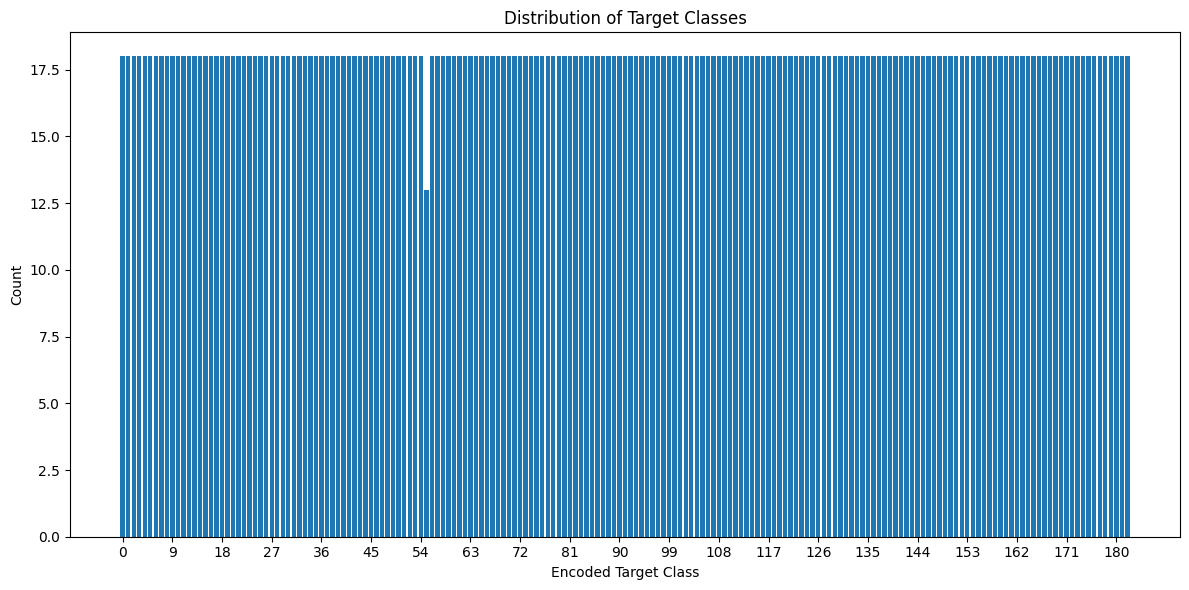


Target distribution summary:
Total classes: 183
Most common class frequency: 18
Least common class frequency: 13


In [18]:
# Feature Importance Analysis
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, y='feature', x='importance')
plt.title('XGBoost Feature Importance for Fungi Classification')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# More detailed analysis
print("\nDetailed Feature Analysis:")
for idx, row in importance_df.iterrows():
    feature = row['feature']
    importance = row['importance']
    print(f"{feature}: {importance:.4f}")
    
    # Show some statistics for this feature
    if feature in X.columns:
        feature_stats = X[feature].describe()
        print(f"  Min: {feature_stats['min']:.2f}, Max: {feature_stats['max']:.2f}, Mean: {feature_stats['mean']:.2f}")
    print()

# Create a correlation matrix for numerical features
numerical_features = ['Latitude', 'Longitude']
if len(numerical_features) > 1:
    plt.figure(figsize=(8, 6))
    correlation_matrix = X[numerical_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

# Print decoded categorical mappings for interpretation
print("\nCategorical Feature Mappings:")
for col in categorical_features:
    le = label_encoders[col]
    mapping = dict(zip(range(len(le.classes_)), le.classes_))
    print(f"\n{col}:")
    for code, category in mapping.items():
        print(f"  {code}: {category}")

# Show target distribution
plt.figure(figsize=(12, 6))
target_counts = pd.Series(y_encoded).value_counts().sort_index()
plt.bar(range(len(target_counts)), target_counts.values)
plt.title('Distribution of Target Classes')
plt.xlabel('Encoded Target Class')
plt.ylabel('Count')
plt.xticks(range(0, len(target_counts), max(1, len(target_counts)//20)))
plt.tight_layout()
plt.show()

print(f"\nTarget distribution summary:")
print(f"Total classes: {len(target_counts)}")
print(f"Most common class frequency: {target_counts.max()}")
print(f"Least common class frequency: {target_counts.min()}")